In [1]:
import sys
sys.path.append('../')

import os
import json
import numpy as np

import torch
import torchvision.transforms as transforms

import models_vit
import models_mae, models_mae_group_channels
import requests
import rasterio
from rasterio.enums import Resampling
from util.fmow_datasets import build_fmow_dataset, SentinelIndividualImageDataset, CATEGORIES

import matplotlib.pyplot as plt
from PIL import Image
from collections import namedtuple

/nlp/scr/samarkhanna/miniconda3/envs/sat_env/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [33]:
# define the utils

imagenet_mean = np.array([0.485, 0.456, 0.406])
imagenet_std = np.array([0.229, 0.224, 0.225])

sent_mean = torch.tensor([1370.19151926, 1184.3824625 , 1120.77120066, 1136.26026392,
                          1263.73947144, 1645.40315151, 1846.87040806, 1762.59530783,
                          1972.62420416,  582.72633433,   14.77112979, 1732.16362238, 1247.91870117])
sent_std = torch.tensor([633.15169573,  650.2842772 ,  712.12507725,  965.23119807,
                         948.9819932 , 1108.06650639, 1258.36394548, 1233.1492281 ,
                         1364.38688993,  472.37967789,   14.3114637 , 1310.36996126, 1087.6020813])

def normalize(array):
    array_min, array_max = array.min(), array.max()
    return ((array - array_min)/(array_max - array_min))

def show_image(image, title=''):
    # image is [H, W, C]
#     assert image.shape[2] == 3
    plt.imshow(torch.clip(image * 255, 0, 255).int())
    plt.title(title, fontsize=16)
    plt.axis('off')
    return

def axis_show_image(ax, image, title=''):
    ax.imshow(torch.clip(image * 255, 0, 255).int())
    ax.set_title(title, fontsize=16)
    ax.axis('off')
    return

def prepare_group_model(chkpt_dir, arch='mae_vit_large_patch16'):
    # build model
    model = getattr(models_mae_group_channels, arch)(img_size=96, patch_size=8, in_chans=10)
    # load model
    checkpoint = torch.load(chkpt_dir, map_location='cpu')
    msg = model.load_state_dict(checkpoint['model'], strict=False)
    print(msg)
    return model

def prepare_spatial_model(chkpt_dir, arch='mae_vit_large_patch16'):
    # build model
    model = getattr(models_mae_group_channels, arch)(img_size=96, patch_size=8, in_chans=10, spatial_mask=True)
    # load model
    checkpoint = torch.load(chkpt_dir, map_location='cpu')
    msg = model.load_state_dict(checkpoint['model'], strict=False)
    print(msg)
    return model

def prepare_stacked_model(chkpt_dir, arch='mae_vit_large_patch16'):
    # build model
    model = getattr(models_mae, arch)(img_size=96, patch_size=8, in_chans=10)
    # load model
    checkpoint = torch.load(chkpt_dir, map_location='cpu')
    msg = model.load_state_dict(checkpoint['model'], strict=False)
    print(msg)
    return model

def run_one_image_group(img, model, show=True, bands=[[2, 1, 0], [5, 4, 3], [9]], dropped=[0, 9, 10]):
#     x = torch.tensor(img)

#     # make it a batch-like
#     x = x.unsqueeze(dim=0)
#     x = torch.einsum('nhwc->nchw', x)
#     x = img.unsqueeze(0)

    # run MAE
    x = img
    loss, y, mask = model(x.float(), mask_ratio=0.75)  # y is shape (N, C, L, p^2)
    
    N, C, L, p_sq = y.shape
    y_viz = torch.einsum('nclp->nlcp', y).reshape(N, L, -1)  # (N, L, C*p^2)
    y = model.unpatchify(y_viz, p=8, c=10)
    y = torch.einsum('nchw->nhwc', y).detach().cpu()

    # visualize the mask
    mask = mask.detach()  # (N, G, L)
    group_mask = []
    for i, g in enumerate(model.channel_groups):
        group_mask.append(mask[:, i:i+1, :].repeat(1, len(g), 1))
    group_mask = torch.cat(group_mask, dim=1)  # (N, C, L)
    
    full_mask = torch.zeros_like(group_mask)
    ctr = 0
    for i, g in enumerate(model.channel_groups):
        full_mask[:, g, :] = group_mask[:, ctr:ctr+len(g), :]
        ctr += len(g)
    
    full_mask = full_mask.unsqueeze(-1).repeat(1, 1, 1, model.patch_embed[0].patch_size[0]**2)  #(N,C,L,p^2)
    full_mask = torch.einsum('nclp->nlcp', full_mask).reshape(N, L, -1)  # (N, L, C*p^2)
    mask = model.unpatchify(full_mask, p=8, c=10)  # 1 is removing, 0 is keeping
    mask = torch.einsum('nchw->nhwc', mask).detach().cpu()
    
    x = torch.einsum('nchw->nhwc', x)
    
    keep_chan_ids = [i for i in range(13) if i not in dropped]
    mean, std = sent_mean[keep_chan_ids], sent_std[keep_chan_ids]
    
    x = x * std + mean
    y = y * std + mean
    
    if show:
        plt.rcParams['figure.figsize'] = [24, 24]
    
    fig, axes = plt.subplots(3, 4)
    
    # make the plt figure larger
    result = []
    for pos, bg in enumerate(bands):
        xg = normalize(x[0, :, :, bg])
        yg = normalize(y[0, :, :, bg])
        maskg = mask[0, :, :, bg]

        # masked image
        im_masked = xg * (1 - maskg)

        # MAE reconstruction pasted with visible patches
        im_paste = xg * (1 - maskg) + yg * maskg
        
        result.append((xg.numpy(), yg.numpy(), im_masked.numpy(), im_paste.numpy()))

        # make the plt figure larger
        if show:
#             plt.subplot(1, 4, 1)
            axis_show_image(axes[pos, 0], xg, "original")
            axis_show_image(axes[pos, 1], im_masked, "masked")
            axis_show_image(axes[pos, 2], yg, "reconstruction")
            axis_show_image(axes[pos, 3], im_paste, "reconstruction + visible")

    if show:
        plt.show()
    
    return result

def run_one_image_stacked(img, model, show=True, bands=[[2, 1, 0], [5, 4, 3], [9]], dropped=[0, 9, 10]):
    # run MAE
    x = img
    loss, y, mask = model(x.float(), mask_ratio=0.75)  # y is shape (N, C, L, p^2)
    
    N, L, p_sq_C = y.shape
    y = model.unpatchify(y, p=8, c=10)
    y = torch.einsum('nchw->nhwc', y).detach().cpu()

    # visualize the mask
    mask = mask.detach()  # (N, L)
    mask = mask.unsqueeze(-1).repeat(1, 1, p_sq_C)  # (N, H*W, p*p*3)
    mask = model.unpatchify(mask, p=8, c=10)  # 1 is removing, 0 is keeping
    mask = torch.einsum('nchw->nhwc', mask).detach().cpu()
    
    x = torch.einsum('nchw->nhwc', x)
    
    keep_chan_ids = [i for i in range(13) if i not in dropped]
    mean, std = sent_mean[keep_chan_ids], sent_std[keep_chan_ids]
    
    x = x * std + mean
    y = y * std + mean
    
    plt.rcParams['figure.figsize'] = [24, 24]
    fig, axes = plt.subplots(3, 4)

    # make the plt figure larger
    result = []
    for pos, bg in enumerate(bands):
        xg = normalize(x[0, :, :, bg])
        yg = normalize(y[0, :, :, bg])
        maskg = mask[0, :, :, bg]

        # masked image
        im_masked = xg * (1 - maskg)

        # MAE reconstruction pasted with visible patches
        im_paste = xg * (1 - maskg) + yg * maskg
        
        result.append((xg.numpy(), yg.numpy(), im_masked.numpy(), im_paste.numpy()))

        # make the plt figure larger
        if show:
            axis_show_image(axes[pos, 0], xg, "original")
            axis_show_image(axes[pos, 1], im_masked, "masked")
            axis_show_image(axes[pos, 2], yg, "reconstruction")
            axis_show_image(axes[pos, 3], im_paste, "reconstruction + visible")

    if show:
        plt.show()

    return result

In [21]:

def normalize(array):
    array_min, array_max = array.min(), array.max()
    return ((array - array_min)/(array_max - array_min))

def read_img(dataset, idx):
    selection = dataset.df.iloc[idx]
    with rasterio.open(selection['image_path']) as data:
#         img = data.read(out_shape=(data.count, 96, 96), resampling=Resampling.bilinear)
        img = data.read()
    return img.transpose(1, 2, 0)

def read_label(ds, idx):
    selection = ds.df.iloc[idx]
    return selection['category']

def read_bands(ds, idx, bands):
    bands = [b -1 for b in bands]
    img = read_img(ds, idx)[:, :, bands]
    return normalize(img)

def to_pil(arr):
    # Squeeze for (H, W, 1) grayscale. Won't do anything for RGB tho
    if arr.shape[-1] == 1:
        arr = arr.squeeze(-1)
    return Image.fromarray((arr*255).astype(np.uint8))

In [4]:
ArgObject = namedtuple('ArgObject', [
    'model', 'batch_size', 'input_size', 'nb_classes', 'train_path', 'test_path', 'dataset_type',
    'masked_bands', 'dropped_bands', 'device', 'seed', 'resume', 'eval', 'num_workers'
])
args = ArgObject(
    model='vit_base_patch16',
    batch_size=1,
    input_size=96,
    train_path='/atlas/u/pliu1/housing_event_pred/data/fmow-sentinel-filtered-csv/train.csv',
    test_path='/atlas/u/pliu1/housing_event_pred/data/fmow-sentinel-filtered-csv/val.csv',
    dataset_type='sentinel',
    masked_bands=None,
    dropped_bands=[0, 9, 10],
    nb_classes=62,
    device='cuda',
    seed=0,
    resume='/atlas/u/samarkhanna/output_finetune_imgnet/checkpoint-9.pth',
    eval=True,
    num_workers=2
)

In [5]:
mean, std = SentinelIndividualImageDataset.mean, SentinelIndividualImageDataset.std
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
    transforms.Resize((args.input_size, args.input_size), interpolation=transforms.InterpolationMode.BICUBIC)
])


dataset_train = SentinelIndividualImageDataset(args.train_path, transform, masked_bands=args.masked_bands,
                                              dropped_bands=args.dropped_bands)
dataset_val = SentinelIndividualImageDataset(args.test_path, transform, masked_bands=args.masked_bands,
                                               dropped_bands=args.dropped_bands)
sampler_val = torch.utils.data.SequentialSampler(dataset_val)
data_loader_train = torch.utils.data.DataLoader(
    dataset_train, shuffle=True, batch_size=args.batch_size, num_workers=args.num_workers, drop_last=False
)
data_loader_val = torch.utils.data.DataLoader(
    dataset_val, sampler=sampler_val,
    batch_size=args.batch_size,
    num_workers=args.num_workers,
    drop_last=False
)

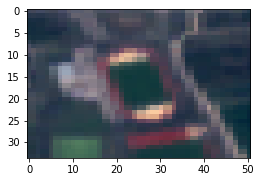

In [6]:
idx = 504000
img = read_bands(dataset_train, idx, [4,3,2])
im = Image.fromarray((img*255).astype(np.uint8))
# plt.imshow(im)
plt.rcParams['figure.figsize'] = [4, 4]
plt.imshow(im)

# Load the models

In [7]:
model = prepare_group_model('/atlas/u/samarkhanna/sentinel_pretrain_group_c_indp_mask_drop0910_96p8/checkpoint-50.pth')
print(model.channel_groups)

<All keys matched successfully>
((0, 1, 2, 6), (3, 4, 5, 7), (8, 9))


In [8]:
model2 = prepare_spatial_model('/atlas/u/samarkhanna/sentinel_pretrain_group_c_spatial_mask_drop0910_96p8/checkpoint-50.pth')
print(model.channel_groups)

<All keys matched successfully>
((0, 1, 2, 6), (3, 4, 5, 7), (8, 9))


In [9]:
model3 = prepare_stacked_model('/atlas/u/samarkhanna/sentinel_pretrain_stacked_drop0910_96p8/checkpoint-50.pth')
print(model3.in_c)

<All keys matched successfully>
10


# Indpendent Mask

In [96]:
# idx = np.random.choice(len(dataset_train))
# idx = 26015
# idx = 683
# idx = 504000
# idx = 446900
# idx = 175673
idx = 420
img, y = dataset_train[idx]
print(idx, CATEGORIES[y])

175673 educational_institution


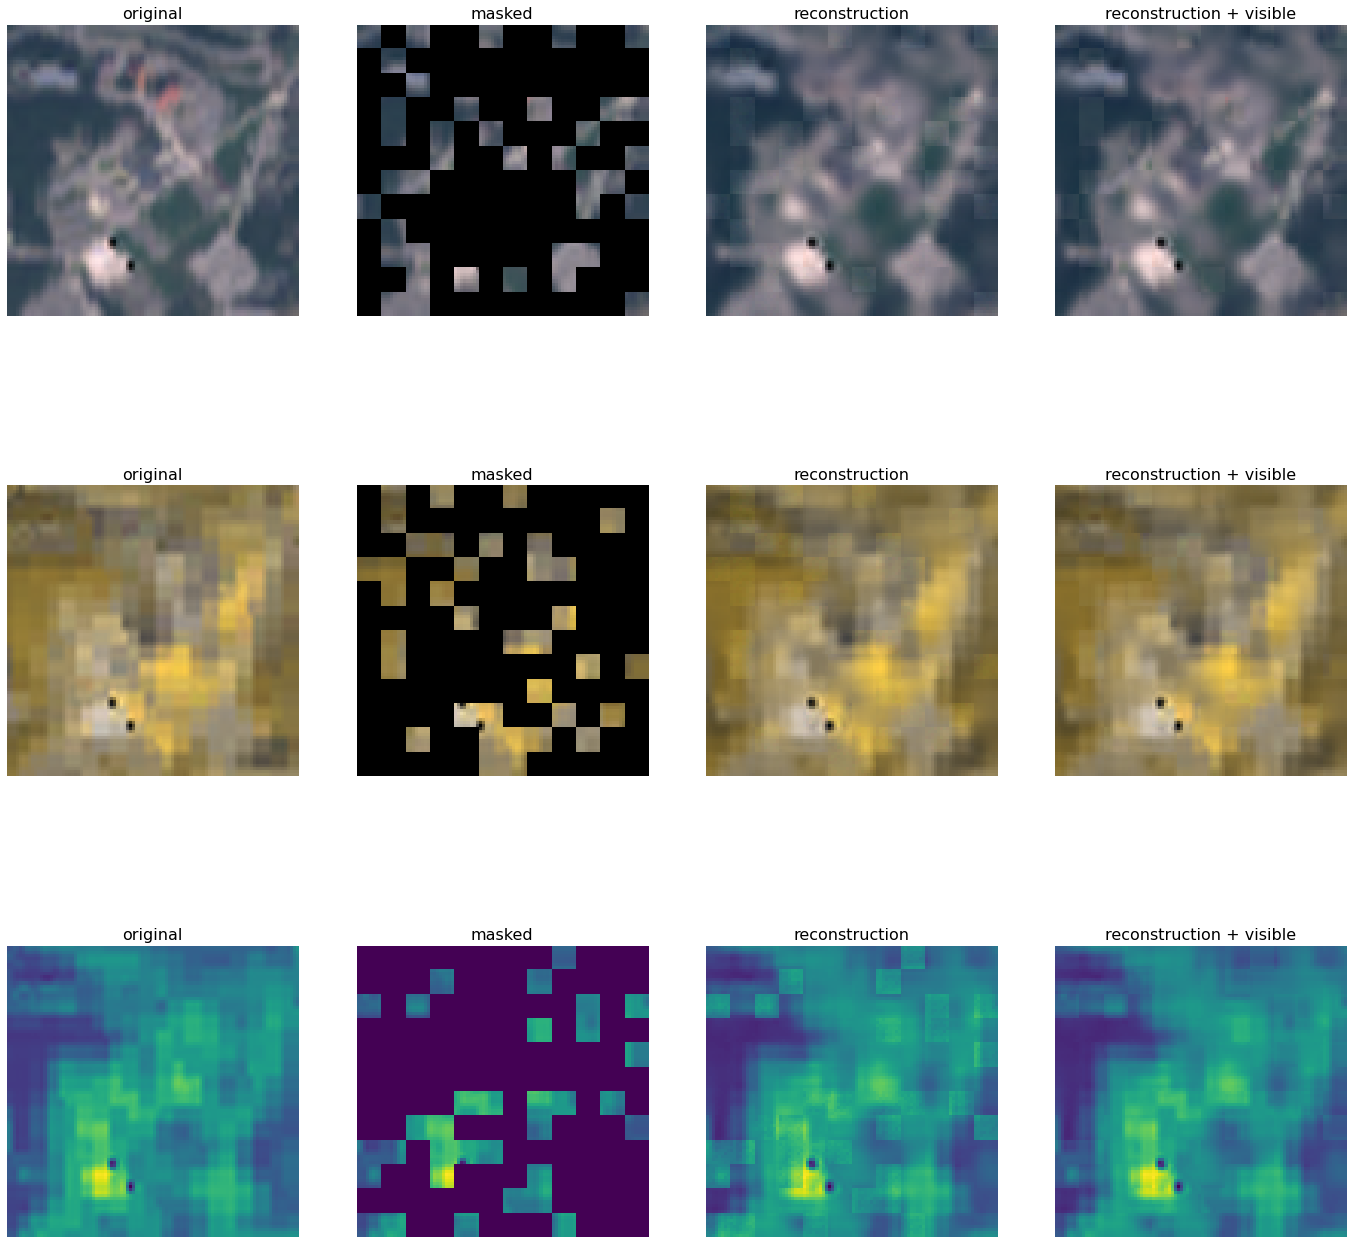

In [97]:
result = run_one_image_group(img.unsqueeze(0), model)
(x_rgb, y_rgb, rgb_masked, rgb_mask_viz), \
(x_nir, y_nir, nir_masked, nir_mask_viz), \
(x_swir, y_swir, swir_masked, swir_mask_viz) = result
# x_rgb, y_rgb, rgb_masked, rgb_mask_viz = run_one_image_group(img.unsqueeze(0), model)
# x_nir, y_nir, nir_masked, nir_mask_viz = run_one_image_group(img.unsqueeze(0), model, bands=[5, 4, 3])
# x_swir, y_swir, swir_masked, swir_mask_viz = run_one_image_group(img.unsqueeze(0), model, bands=[9])

In [98]:
base_dir = '../figures/sentinel_inpaint'
os.makedirs('../figures/sentinel_inpaint', exist_ok=True)

In [99]:
x_rgb, y_rgb, rgb_masked, rgb_mask_viz = to_pil(x_rgb), to_pil(y_rgb), to_pil(rgb_masked), to_pil(rgb_mask_viz)
x_nir, y_nir, nir_masked, nir_mask_viz = to_pil(x_nir), to_pil(y_nir), to_pil(nir_masked), to_pil(nir_mask_viz)
x_swir, y_swir, swir_masked, swir_mask_viz = to_pil(x_swir), to_pil(y_swir), to_pil(swir_masked), to_pil(swir_mask_viz)

im_dict = {
    'rgb': [x_rgb, y_rgb, rgb_masked, rgb_mask_viz],
    'nir': [x_nir, y_nir, nir_masked, nir_mask_viz],
    'swir': [x_swir, y_swir, swir_masked, swir_mask_viz]
}
label = CATEGORIES[y]
print(label)

educational_institution


In [100]:
order = ['original', 'reconstruction', 'masked', 'masked_viz']
for g, ims in im_dict.items():
    for desc, im in zip(order, ims):
        im.save(os.path.join(base_dir, f'{idx}_{label}_indp_{g}_{desc}.png'))

# Spatial Mask

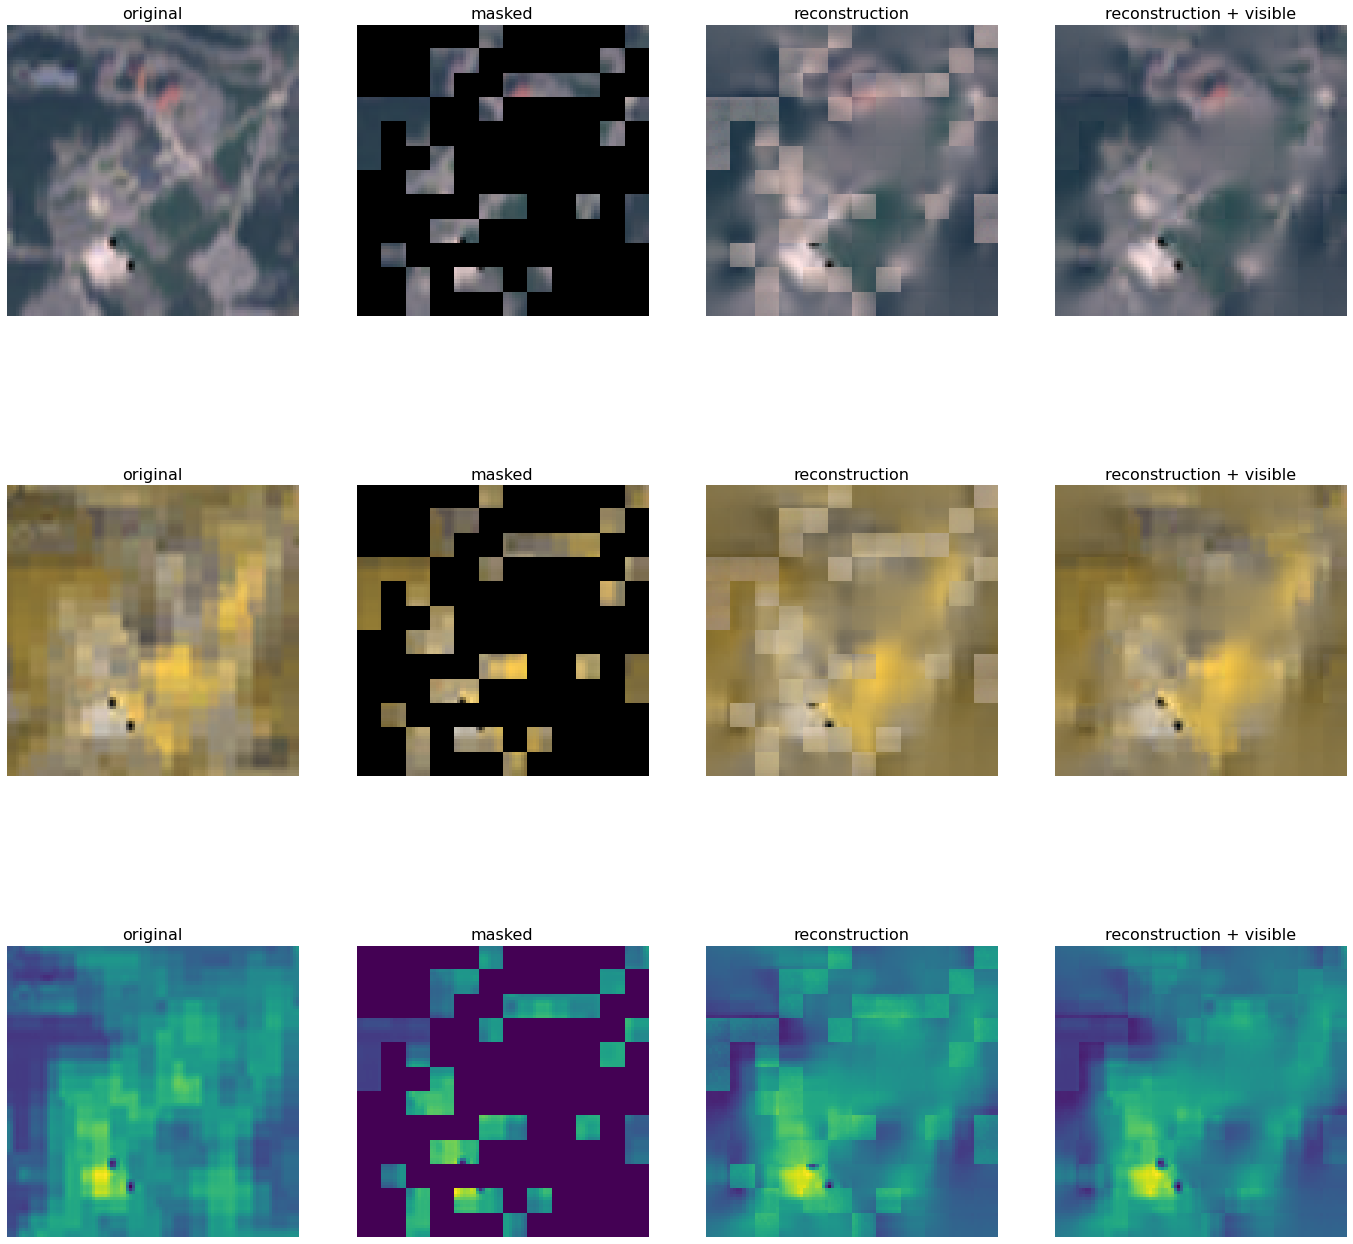

In [101]:
result = run_one_image_group(img.unsqueeze(0), model2)
(x_rgb, y_rgb, rgb_masked, rgb_mask_viz), \
(x_nir, y_nir, nir_masked, nir_mask_viz), \
(x_swir, y_swir, swir_masked, swir_mask_viz) = result

In [102]:
x_rgb, y_rgb, rgb_masked, rgb_mask_viz = to_pil(x_rgb), to_pil(y_rgb), to_pil(rgb_masked), to_pil(rgb_mask_viz)
x_nir, y_nir, nir_masked, nir_mask_viz = to_pil(x_nir), to_pil(y_nir), to_pil(nir_masked), to_pil(nir_mask_viz)
x_swir, y_swir, swir_masked, swir_mask_viz = to_pil(x_swir), to_pil(y_swir), to_pil(swir_masked), to_pil(swir_mask_viz)

im_dict = {
    'rgb': [x_rgb, y_rgb, rgb_masked, rgb_mask_viz],
    'nir': [x_nir, y_nir, nir_masked, nir_mask_viz],
    'swir': [x_swir, y_swir, swir_masked, swir_mask_viz]
}
label = CATEGORIES[y]
print(label)

educational_institution


In [103]:
order = ['original', 'reconstruction', 'masked', 'masked_viz']
for g, ims in im_dict.items():
    for desc, im in zip(order, ims):
        im.save(os.path.join(base_dir, f'{idx}_{label}_spatial_{g}_{desc}.png'))

# Stacked

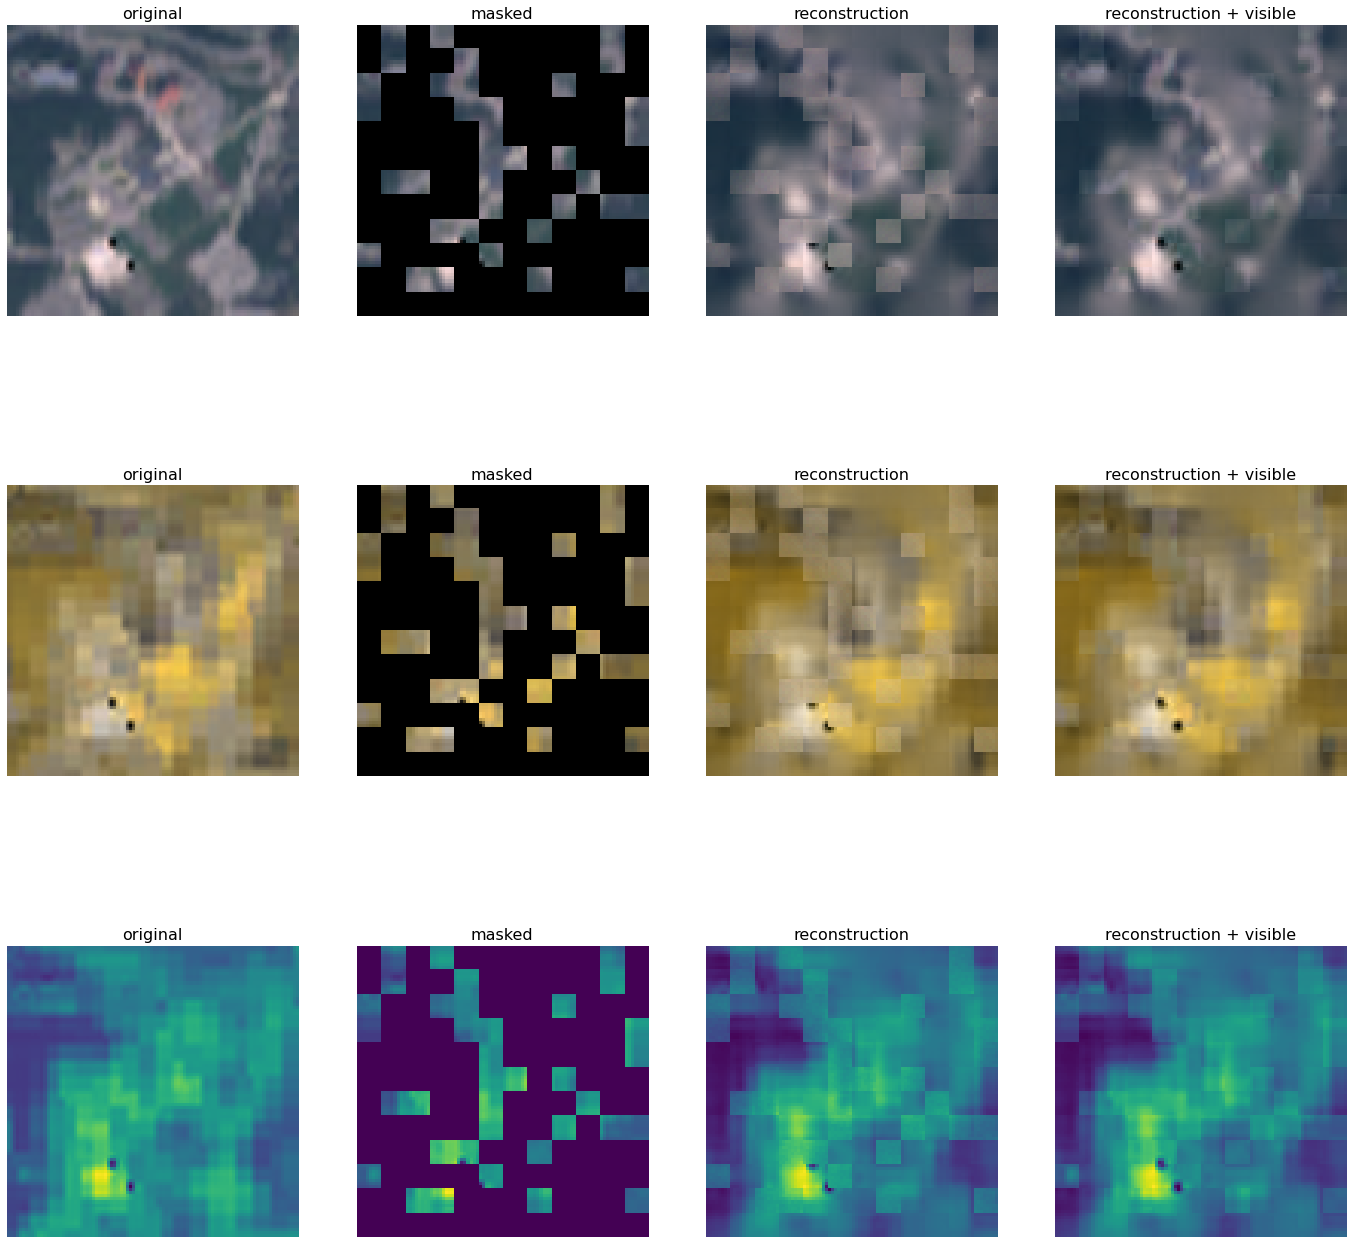

In [104]:
result = run_one_image_stacked(img.unsqueeze(0), model3)
(x_rgb, y_rgb, rgb_masked, rgb_mask_viz), \
(x_nir, y_nir, nir_masked, nir_mask_viz), \
(x_swir, y_swir, swir_masked, swir_mask_viz) = result

In [105]:
x_rgb, y_rgb, rgb_masked, rgb_mask_viz = to_pil(x_rgb), to_pil(y_rgb), to_pil(rgb_masked), to_pil(rgb_mask_viz)
x_nir, y_nir, nir_masked, nir_mask_viz = to_pil(x_nir), to_pil(y_nir), to_pil(nir_masked), to_pil(nir_mask_viz)
x_swir, y_swir, swir_masked, swir_mask_viz = to_pil(x_swir), to_pil(y_swir), to_pil(swir_masked), to_pil(swir_mask_viz)

im_dict = {
    'rgb': [x_rgb, y_rgb, rgb_masked, rgb_mask_viz],
    'nir': [x_nir, y_nir, nir_masked, nir_mask_viz],
    'swir': [x_swir, y_swir, swir_masked, swir_mask_viz]
}
label = CATEGORIES[y]
print(label)

educational_institution


In [106]:
order = ['original', 'reconstruction', 'masked', 'masked_viz']
for g, ims in im_dict.items():
    for desc, im in zip(order, ims):
        im.save(os.path.join(base_dir, f'{idx}_{label}_stacked_{g}_{desc}.png'))